In [85]:
import pandas as pd
import numpy as np
import uci_dataset as database
import torch

from raimitigations.utils import train_model_plot_results, split_data
import raimitigations.dataprocessing as dp

# Case Study 2

## Fixing a seed

To avoid randomness in the following experiments, we'll fix the seeds to guarantee that the results obtained are the same each time we run this notebook. Feel free to comment the next cell or test different seeds to see how this affects the results.

In [86]:
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## 1 - Understanding the Data

In this example, we will build a classifier to detect diseased trees using the `dataprocessing` library, with data from the `uci_dataset`. The data itself comes from spectral imagery, and the data columns relate to features in the imagery.

The data columns have the following meaning:

- class: 'w' (diseased trees), 'n' (all other land cover)
- GLCM_Pan: GLCM mean texture (Pan band)
- Mean_G: Mean green value
- Mean_R: Mean red value
- Mean_NIR: Mean NIR value
- SD_Pan: Standard deviation (Pan band)

In [87]:
df = database.load_wilt()
label_col = "class"
df

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,w,120.362774,205.500000,119.395349,416.581395,20.676318
1,w,124.739583,202.800000,115.333333,354.333333,16.707151
2,w,134.691964,199.285714,116.857143,477.857143,22.496712
3,w,127.946309,178.368421,92.368421,278.473684,14.977453
4,w,135.431548,197.000000,112.690476,532.952381,17.604193
...,...,...,...,...,...,...
495,n,123.554348,202.826087,106.391304,364.565217,17.314068
496,n,121.549028,276.220000,175.593333,402.620000,13.394574
497,n,119.076687,247.951220,113.365854,808.024390,24.830059
498,n,107.944444,197.000000,90.000000,451.000000,8.214887


In [88]:
df[label_col] = df[label_col].replace({"w": 1, "n": 0})
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4839 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       4839 non-null   int64  
 1   GLCM_pan    4839 non-null   float64
 2   Mean_Green  4839 non-null   float64
 3   Mean_Red    4839 non-null   float64
 4   Mean_NIR    4839 non-null   float64
 5   SD_pan      4839 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 264.6 KB


In [89]:
df.isna().any()

class         False
GLCM_pan      False
Mean_Green    False
Mean_Red      False
Mean_NIR      False
SD_pan        False
dtype: bool

First, we will try to determine if any of the features are correlated, and remove the correlated features.

In [90]:
cor_feat = dp.CorrelatedFeatures(
					method_num_num=["spearman", "pearson", "kendall"],				# Used for Numerical x Numerical correlations
					num_corr_th=0.9,												# Used for Numerical x Numerical correlations
					num_pvalue_th=0.05,												# Used for Numerical x Numerical correlations
					method_num_cat="model",											# Used for Numerical x Categorical correlations
					model_metrics=["f1", "auc"],									# Used for Numerical x Categorical correlations
					metric_th=0.9,													# Used for Numerical x Categorical correlations
					cat_corr_th=0.9,												# Used for Categorical x Categorical correlations
					cat_pvalue_th=0.01,												# Used for Categorical x Categorical correlations
					json_summary="./corr_json/c2_summary.json",
					json_corr="./corr_json/c2_corr.json",
					json_uncorr="./corr_json/c2_uncorr.json"
				)
cor_feat.fit(df=df, label_col=label_col)

No correlations detected. Nothing to be done here.


Remember to look through the JSON files generated in the previous cell. But, according to the thresholds we have set, no features are correlated.

## 2 - Baseline Models

In [91]:
df[label_col].value_counts()

0    4578
1     261
Name: class, dtype: int64

In this example, we have an imbalanced dataset (most trees are not diseased). While we will take a look at a number of different metrics, we will be focused on improved the F1 score for this dataset.

After splitting the data into train and test sets, we will build two baseline models, one with XGBoost, and the other with KNN.

In [92]:
train_x, test_x, train_y, test_y = split_data(df, label_col, test_size=0.25)

------------
TEST
------------
[[1115   30]
 [   6   59]]


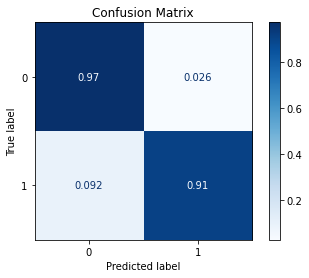

Acuracy: 97.02%

Precision:  0.8287844921769287

Recall:  0.9407457171649312

F1 =  0.8751733703190014

ROC AUC =  0.9681558616056434


In [93]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False, plot_pr=False)

------------
TEST
------------
[[1120   25]
 [   8   57]]


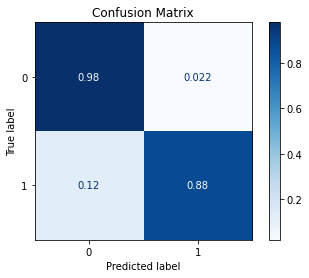

Acuracy: 97.27%

Precision:  0.8440148763189759

Recall:  0.9275445078938529

F1 =  0.8804959731362849

ROC AUC =  0.9348202888814242


In [94]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="knn", train_result=False, plot_pr=False)

For a baseline, XGBoost and KNN have F1 scores around 0.86 (this will depend on your train/test split if you rerun this notebook). We will now proceed to try and improve on these results.

## 3 - Data Transformation

### DataMinMaxScaler

The first data transformation we will perform is a MinMaxScaler, which will scale each feature to have a range between zero and one. This does not improve the results.

------------
TEST
------------
[[1018  127]
 [  23   42]]


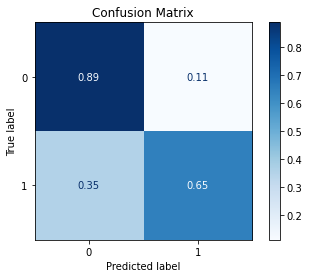

Acuracy: 87.60%

Precision:  0.6132132849047058

Recall:  0.7676184077930803

F1 =  0.6451779388650385

ROC AUC =  0.7821296607322807


In [95]:
scaler = dp.DataMinMaxScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataNormalizer

Next we try `DataNormalizer`, which will scale the vectors to have unit norm (i.e. vector of length one). This is often used in text classification, but we will use it here as well. But it does not improve the results.

No columns specified for imputation. These columns have been automatically identified:
[]
------------
TEST
------------
[[1089   56]
 [   6   59]]


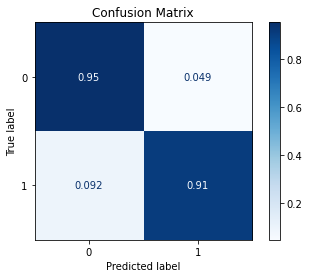

Acuracy: 94.88%

Precision:  0.7537820131030375

Recall:  0.9293920053745381

F1 =  0.8139384920634921

ROC AUC =  0.9453745381256298


In [96]:
scaler = dp.DataNormalizer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataStandardScaler

The standard scaler sets the mean to zero and scales the vectors to have unit variance.

------------
TEST
------------
[[1088   57]
 [  15   50]]


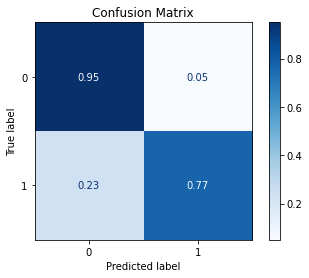

Acuracy: 94.05%

Precision:  0.7268452224604096

Recall:  0.8597245549210615

F1 =  0.7746834395431599

ROC AUC =  0.8714746388982196


In [97]:
scaler = dp.DataStandardScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataQuantileTransformer

The Quantile Transformer transforms the each feature to have a normal distribution.

------------
TEST
------------
[[1113   32]
 [  10   55]]


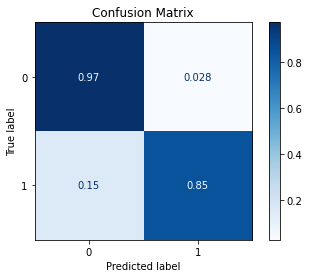

Acuracy: 96.53%

Precision:  0.8116395942723207

Recall:  0.9091031239502856

F1 =  0.8525828460038987

ROC AUC =  0.917991266375546


In [98]:
scaler = dp.DataQuantileTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataPowerTransformer

The power transformer makes the data more Gaussian-like (by default using the Yeo-Johnson transform).

------------
TEST
------------
[[1118   27]
 [   7   58]]


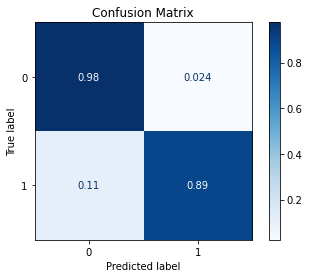

Acuracy: 97.19%

Precision:  0.8380653594771241

Recall:  0.9343634531407458

F1 =  0.8791776798825257

ROC AUC =  0.9416392341283171


In [99]:
scaler = dp.DataPowerTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataRobustScaler

The robust scaler centers the data (median=zero) and scales the data based on the interquartile range (IQR).

------------
TEST
------------
[[1121   24]
 [   5   60]]


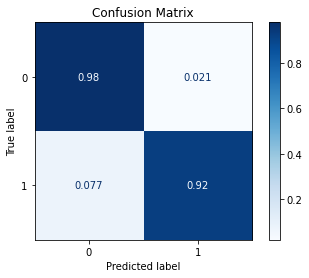

Acuracy: 97.60%

Precision:  0.8549226084750063

Recall:  0.9510581121934834

F1 =  0.8962997112704985

ROC AUC =  0.9579711118575748


In [100]:
scaler = dp.DataRobustScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

As we can see, this transformation had some impact in the results (depends on the seed used) when we use KNN. Let's check how this data transformation impacts the XGBoost model:

------------
TEST
------------
[[1115   30]
 [   6   59]]


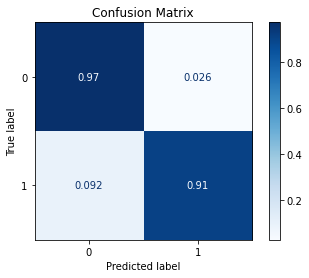

Acuracy: 97.02%

Precision:  0.8287844921769287

Recall:  0.9407457171649312

F1 =  0.8751733703190014

ROC AUC =  0.9681558616056434


In [101]:
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="xgb", train_result=False, plot_pr=False)

As depicted above, the results for the XGBoost remains the same as before. This shows us that data transformations are more impactful in certain models and less meaningful in others.

## 4 - Feature Selection

By using data scaling (Robust Scaler), we managed to get a small performance increase. We now proceed to use feature selection over the dataset and see if we can manage to get an even higher performance. We start out with 5 features, and use feature selection to remove unneeded features.

In [102]:
feat_sel = dp.CatBoostSelection(steps=5, verbose=False)
feat_sel.fit(X=train_x_scl, y=train_y)
train_x_sel = feat_sel.transform(train_x_scl)
test_x_sel = feat_sel.transform(test_x_scl)

The number of features selection steps (5) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


In [103]:
feat_sel.get_selected_features()

['Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']

Here, ``CatBoostSelection`` feature selection has removed one of the features (GLCM_pan).

------------
TEST
------------
[[1124   21]
 [   5   60]]


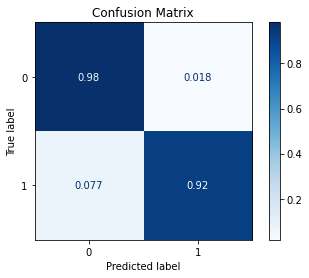

Acuracy: 97.85%

Precision:  0.8681560213889709

Recall:  0.9523681558616057

F1 =  0.9052421055168011

ROC AUC =  0.9586362109506215


In [104]:
model = train_model_plot_results(train_x_sel, train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

From the previous results, we can see that we removed one of the features, but without any noticeable gains in performance. However, we are now achieving the same metrics using less data, so we can already call it successful pre-processing step.

## 5 - Synthetic Data

### imblearn Library

With unbalanced classes, we can instead choose to create synthetic data for the minority class. Here we use `Rebalance`, which connects to the `imblearn` library.

In [105]:
train_y.value_counts()

0    3433
1     196
Name: class, dtype: int64

In [106]:
rebalance = dp.Rebalance(
				X=train_x_sel,
				y=train_y,
				strategy_over={0:3433, 1:400},
				over_sampler=True,
				under_sampler=False
			)
train_x_res, train_y_res = rebalance.fit_resample()
train_y_res.value_counts()

No columns specified for imputation. These columns have been automatically identified:
[]
Running oversampling...
...finished


0    3433
1     400
Name: class, dtype: int64

------------
TEST
------------
[[1122   23]
 [   5   60]]


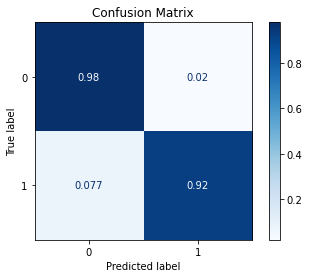

Acuracy: 97.69%

Precision:  0.8592275045167359

Recall:  0.9514947934161908

F1 =  0.8992434335744195

ROC AUC =  0.9583338931810548


In [107]:
model = train_model_plot_results(train_x_res, train_y_res, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

Similarly to the feature selection step, using the **Rebalance** class didn't provide any considerable gains.

### Creating Artificial Data using Deep Learning

#### CTGAN

Let's now test rebalancing the dataset using CTGAN:

In [108]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=200,
				model="ctgan",
				load_existing=False
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

syn_train_y.value_counts()

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warning

0    3433
1     396
Name: class, dtype: int64

------------
TEST
------------
[[1083   62]
 [   4   61]]


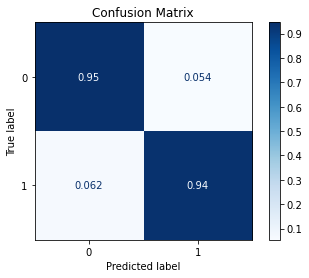

Acuracy: 94.55%

Precision:  0.7461275532718529

Recall:  0.942156533422909

F1 =  0.8096831388698238

ROC AUC =  0.9631776956667787


In [109]:
model = train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

Let's try creating more artificial instances and check how this impacts the model's performance.

------------
TEST
------------
[[1100   45]
 [   6   59]]


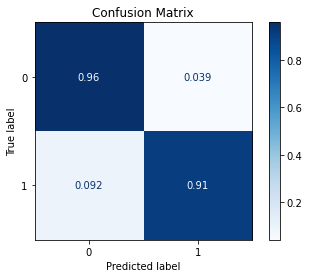

Acuracy: 95.79%

Precision:  0.7809413687578244

Recall:  0.9341954988243197

F1 =  0.8377841275015181

ROC AUC =  0.9658649647295936


In [110]:
conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=2000, conditions=conditions)

model = train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

#### TVAE

In [111]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=200,
				model="tvae",
				load_existing=False
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn2_train_x, syn2_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warning

------------
TEST
------------
[[1037  108]
 [   2   63]]


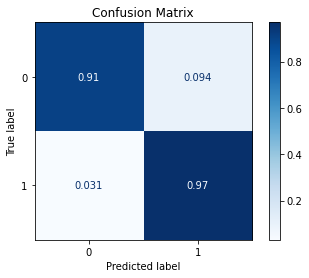

Acuracy: 90.91%

Precision:  0.683248062408186

Recall:  0.9374538125629829

F1 =  0.7417660023592227

ROC AUC =  0.9730332549546523


In [112]:
model = train_model_plot_results(syn2_train_x, syn2_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)